# Algorytm k najbliższych sąsiadów (KNN)

27 listopad 2017

#### Wstęp

Metoda k najbliższych sąsiadów jest metodą uczenia maszynowego z nadzorem ale również może być wykorzystywana do ucznia bez nadzoru czyli bez nauczyciela. To czy nasz problem wymaga algorytmu z nauczycielem czy bez w prosty sposób mozna rozróżnić po tym czy posiadamy w naszym zbiorze uczącym daną wyjściową. Jeżeli posiadamy wtedy możemy użyć metody z nauczycielem, która robi nic więcej jak dopasowuje paramtery naszego modelu do danej wyjściowej. Jeżeli nie posadamy danej wyjściowej czyli nie wiemy jak w rzeczywistości nasze dane są pogrupowane pozostają name metody bez nauczyciela. 

Algorytm metody szuka k najbliżej położone punkty (najczęściej wg miary odległości Euklidesowej ale wykorzystywana metoda ukrywająca się pod pojęciem "najbliższa" można zdefiniować dowolnie), zlicza liczebność poszczególnych klas wśród sąsiadów i klasyfikuje nieznany punkt do tej grupy która jest bardziej liczna.

Metoda KNN należy do metod nieparametrycznych tzn. że nie zakłada nic o rozkładzie zmiennych wejściowych (jak wiele innych klasycznych metod statystycznych), jest odporna na wartości odstające i daje dobre wyniki w przypadkach gdy granice decyzyjne (decision boundary) są bardzo nieregularne.

Prezentowany materiał zakłada znajomość podstaw pythona i statystyki.


#### Narzędzia

Do budowy modelu, analizy i prezentacji wyników użyty zostanie pakiet narzędzi scikit-learn, numpy, pandas oraz matplotlib.


*Importujemy wszystkie potrzebne biblioteki*

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.datasets
import sklearn.decomposition
import sklearn.model_selection
#import sklearn.cross_validation
import sklearn.neighbors
import sklearn.metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,f1_score, confusion_matrix, roc_curve, auc)

*Dane wejściowe pochodzą ze zbioru danych UCI (https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) i dotyczą wyników marketingu bezpośredniego dla jednego z portugalskich instytucji bankowych*

In [2]:
# Load CSV and columns
df = pd.read_csv("bank.csv", sep=';')
y_di = {"yes": 1, "no": 0}
df = df.replace({"y": y_di})

*Ostatnia kolumna "y" to wynik kampanii: 1 - klient odpowiedział pozytywnie na ofertę, 0 - to wynik negatywny *

In [3]:
df.head(n=5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0


*Rozdzielamy dane na dwie grupy. Y to nasza dana wyjściowa a X to nasze dane wejściowe na podstawie której będziemy przewidywali wynik naszej kampanii*

In [4]:
Y = df['y']

X = df.drop('y', axis=1)

*Aby można było wykorzystać nasze dane wejściowe do predykcji zachowań klientów zmienne jakościowe należy zamienić na zmienną numeryczną. Wykonywane jest to w ten sposób, że kolumna posiadająca dwie wartości np. yes/no jest rozdzielana na dwie zmienne - zmienna przyjmującą 1 dla wszystkich przypadków dla których wartość jest równa yes i drugą kolumnę która przyjmuje 1 dla wartości no*

In [5]:
cols_to_transform = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
X_conv = pd.get_dummies(X, columns = cols_to_transform )
X_conv.head(n=5)

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,33,4789,11,220,1,339,4,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,35,1350,16,185,1,330,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,30,1476,3,199,4,-1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,59,0,5,226,1,-1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


*Dane dzielimy na dwie grupy - dane treningowe i dane testowe*

In [6]:
from sklearn.preprocessing import scale

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    X_conv, Y, test_size=0.33, random_state=42)

X_train.head(n=5)

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
1138,35,56,29,24,12,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
209,56,1333,28,17,14,-1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2609,57,-226,4,272,1,-1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2110,31,-498,21,357,1,-1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2124,43,291,9,150,2,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


*Dane przed predykcją dobrze jest również wycentrować do średniej i przeskalować do wariancji*

In [7]:
X_conv['age'] = X_conv['age'].astype(float)
X_conv['balance'] = X_conv['balance'].astype(float)
X_conv['duration'] = X_conv['duration'].astype(float)

X_conv['age'] = scale(X_conv['age'])
X_conv['balance'] = scale(X_conv['balance'])
X_conv['duration'] = scale(X_conv['duration'])

X_conv.head(n=5)

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,-1.056270,0.121072,19,-0.711861,1,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,-0.772583,1.118644,11,-0.169194,1,339,4,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,-0.583458,-0.024144,16,-0.303898,1,330,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,-1.056270,0.017726,3,-0.250017,4,-1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,1.686036,-0.472753,5,-0.146102,1,-1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1


*Pierwszy z ciekawszych momentów analizy czyli redukcja wymiarów. Reducja wymiarów PCA to temat sam w sobie dosyć obszerny i w sktórcie polega a przekształceniu danych tak aby przy najmniejszej stracie zredukować liczbe wymiarów do zadanej przez nas liczby. W naszym przypadku dane wielowymiarowe chcemy w jakiś sposób przedstawić na dwuwymiarowym wykresie*

In [8]:
svd = sklearn.decomposition.TruncatedSVD(n_components=2)
X_2d = svd.fit_transform(X_train)

*Przedstawiamy dwie pierwsze składowe czyli te które niosą największą liczbę informacji. Jak widzimy dane nie są w oczywisty sposób separowalne co będzie miało określone konsekwencje w budowie naszego modelu*

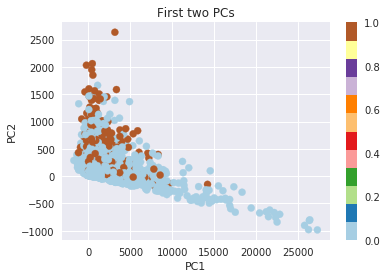

In [9]:
sns.set()

plt.scatter(X_2d[:,0], X_2d[:,1], c=Y_train, s=50, cmap=plt.cm.Paired)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('First two PCs')

plt.show()

*Drugim tematem który należy poruszyć w tym momencie to n-krotna walidacja krzyżowa. Polega ona na podziale próby treningowej na n podprób a następnie budowane są kolejno modele w oparciu o wszystkie próby z wyłączeniem jednej, kolejnej podpróby która służy do testowania zbudowanego tak modelu.*

*Poniższy kod jest odpowiedzialny za dwie rzeczy. Pierwsza z nich to wybór optymalnej liczby sąsiadów - czyli liczby k a drugi to wybór optymalnej liczby wymiarów do redukcji. Za wybór odpowiedniej liczby k odpowiedzialna jest klasa GridSearchCV.*

*W pętli redukujemy liczbę wymiarów do zadanej liczby i budujemy Model KNN szukając optymalnej liczby redukowanych wymiarów poprzez sprawdzanie parametru precyzji (accuracy) dla każdej podopróby i dla każdego wymiaru redukcji*

In [10]:
k = np.arange(20)+1
parameters = {'n_neighbors': k}

knearest = sklearn.neighbors.KNeighborsClassifier()
clf = sklearn.model_selection.GridSearchCV(knearest, parameters, cv=10)

accuracy = []
params = []

n_of_dimensions = [2,3,4,6,8,10]

for d in n_of_dimensions:
    svd = sklearn.decomposition.TruncatedSVD(n_components=d)
    
    X_fit = svd.fit_transform(X_train)
    X_fit_test = svd.transform(X_test)
    
    clf.fit(X_fit, Y_train)
    
    accuracy.append( cross_val_score(clf, X_fit_test, Y_test, cv=10) )
    params.append(clf.best_params_['n_neighbors'])

*Wynikiem jest tabela prezentująca średnią wartość precyzji (mean_accuracy) dla wybranej liczby k sąsiadów (n_neighbors) i wybranej liczby wymiarów redukcji (n_of_dimensions) *

In [11]:
output = pd.DataFrame(list(zip(params, np.array(accuracy).mean(axis=1))), columns=['n_neighbors', 'mean_accuracy'])
output['n_of_dimensions']=n_of_dimensions
output

,n_neighbors,mean_accuracy,n_of_dimensions
0,14,0.888079,2
1,17,0.888732,3
2,18,0.888732,4
3,17,0.888065,6
4,17,0.888065,8
5,17,0.888065,10


*Aby ocenić jakość zbudowanego modelu należy obliczyć kilka parametrów z których najważniejszymi jest precyzja (precision) i czułość (recall)*

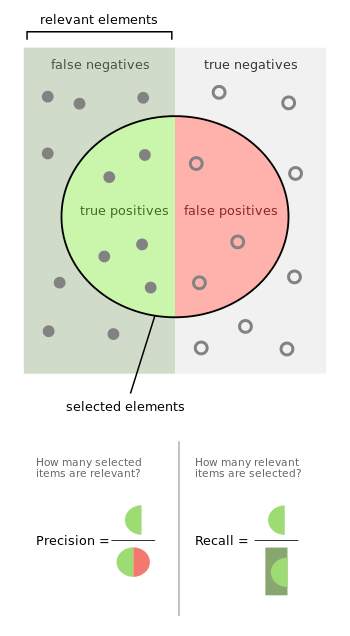

*Do grupy innych parametrów należą jeszcze wszystkie poniższe z których najważniejszym jest ACC choć w ocenie zdolności predykcji modelu należy uwzględniać oba parametry TPR i TNR*

*TPR (True Positive Rate) – określa zdolność klasyfikatora do wykrywania klasy pozytywnej (stanu patologicznego)*
*TPR = TP / (TP + FN)*

*TNR (True Negative Rate) – określa zdolność klasyfikatora do wykrywania klasy negatywnej (stanu normalnego)*
*TNR = TN / (TN + FP)*

*FPR (False Positive Rate) – określa, jak często klasyfikator popełnia błąd, klasyfikując stan normalny jako patologiczny*
*FPR = FP / (FP + TN)*

*FNR (False Negative Rate) – określa, jak często klasyfikator popełnia błąd, klasyfikując stan patologiczny jako normalny*
*FNR = FN / (FN + TP)*

*SE (sensitivity, czułość) – określa zdolność klasyfikatora do wykrywania klasy pozytywnej (stanu patologicznego)*
*SE = TP / (TP + FN)*

*SP (specificity, specyficzność) – określa zdolność klasyfikatora do wykrywania klasy negatywnej (stanu normalnego)*
*SP = TN / (TN + FP)*

*Przy czym, istnieją takie zależności:*
*SE = TPR 1 – SE = FNR*
*SP = TNR 1-SP = FPR*

*ACC (Total Accuracy) – całkowita sprawność klasyfikatora, określa prawdopodobieństwo poprawnej klasyfikacji, czyli stosunek poprawnych klasyfikacji do wszystkich klasyfikacji*
*ACC = (TP + TN) / (TP + TN + FP + FN)*

*Jak widzimy nasz model ma całkiem wysobie ACC wynoszące 89% ale jeżeli spoglądniemy na parametry TPR i TNR to zauważymy, że wysoka wartość ACC wynika głównie z wysokiej zdolności do przewidywania klasy negatywnej. Zdolność wykrywania klasy pozytywnej jest bardzo niska i wynosi zaledwie 16%. Wniosek z tego jest następujący aby do oceny modelu nie używać jedynie wartości parametru ACC*

In [27]:
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=18)
svd = sklearn.decomposition.TruncatedSVD(n_components=4)

X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

clf.fit(X_train_svd, Y_train)


y_test = Y_test
y_pred = clf.predict(X_test_svd)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
se = tp / (tp + fn)
sp = tn / (tn + fp)
acc = (tp + tn) / (tp + tn + fp + fn)

print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))
print("\tTPR: %f" % tpr)
print("\tTNR: %f" % tnr)
print("\tFPR: %f" % fpr)
print("\tFNR: %f" % fnr)
print("\tSE:  %f" % se)
print("\tSP:  %f" % sp)
print("\tACC: %f" % acc)

	Precision: 0.542
	Recall: 0.165
	F1: 0.252

	TPR: 0.164557
	TNR: 0.983508
	FPR: 0.016492
	FNR: 0.835443
	SE:  0.164557
	SP:  0.983508
	ACC: 0.896783


*Innym przydatnym narzędziemy do oceny jakości modelu jest krzywa ROC. Jest to zależność pomiedzy parametrami TP i FP przy zmieniających się wartościach parametru odcięcia alfa. Aby to lepiej zrozumieć należy uzmysłowić sobie, że wynik klasyfikacji w zbudowanym przez nas modelu nie jest wartościa binarną zero-jedynkową. Na wyjściu modelu mamy wartość prawdopodobieństwa. W domyślnym przypadku próg odcięcia jest ustawiony na 50% czyli wszystko powyżej jest klasyfikowane jako true a wszystko poniżej jako false. Ale gdy zaczniemy wyznaczać wartości TP i FP zmieniając ten próg alfa a otrzymane wyniki naniesiemy na wykres to otrzymamy krzywą ROC*

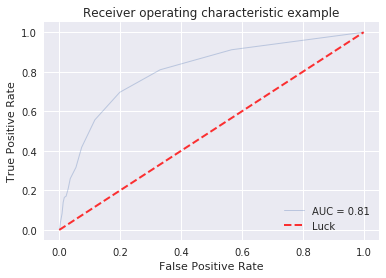

In [13]:
probas_  = clf.fit(X_train, Y_train).predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

*Aby sprawdzić jaki jest wpływ redukcji wymiarów budujemy model bez redukcji*

In [30]:
clf = sklearn.model_selection.GridSearchCV(knearest, parameters, cv=10)
clf.fit(X_train, Y_train)
scores = cross_val_score(clf, X_test, Y_test, cv=10)

y_test = Y_test
y_pred = clf.predict(X_test)

*Jak widzimy wartość ACC jest o 1% niższa podobnie jak i precyzja. Czułość jest o jeden procent wyższa. Wszystko to pokazuje, że redukcja wymiarów może mieć pozytywny wpływ na budowany przez nas model*

In [35]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
se = tp / (tp + fn)
sp = tn / (tn + fp)
acc = (tp + tn) / (tp + tn + fp + fn)

print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

print("\tTPR: %f" % tpr)
print("\tTNR: %f" % tnr)
print("\tFPR: %f" % fpr)
print("\tFNR: %f" % fnr)
print("\tSE:  %f" % se)
print("\tSP:  %f" % sp)
print("\tACC: %f" % acc)

	Precision: 0.491
	Recall: 0.171
	F1: 0.254

	TPR: 0.170886
	TNR: 0.979010
	FPR: 0.020990
	FNR: 0.829114
	SE:  0.170886
	SP:  0.979010
	ACC: 0.893432


*Jeżeli zbadamy jaki procent wszystkich wyników stanowią jedynki (10%) to nasza precyzja jest na dostatecznie zadawalającym poziomie ale czułość jest tylko o kilka procent lepsza od wartości uzyskanej w generatorze losowym co źle świadczy o naszym modelu*

In [37]:
frac = y_test.sum()/y_test.size
print("\tFrac: %1.3f" % frac)

	Frac: 0.106


*Rysujemy krzywą ROC dla modelu bez redukcji PCA*

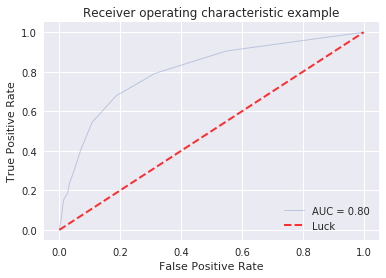

In [38]:
probas_  = clf.fit(X_train, Y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

*A co jeżeli zastosujemy inny model np. nawiny klasyfikator Bayes'a?*

In [41]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, Y_train)
scores = cross_val_score(gnb, X_test, Y_test, cv=10)

y_test = Y_test
y_pred = gnb.predict(X_test)

*Widzimy, że tak na szybko zbudowany model daje nam o wiele większą zdolność do przewidywania wartości pozytywnych pomimo tego, że wartości negatywne przewiduje gorzej*

In [43]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
se = tp / (tp + fn)
sp = tn / (tn + fp)
acc = (tp + tn) / (tp + tn + fp + fn)

print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

print("\tTPR: %f" % tpr)
print("\tTNR: %f" % tnr)
print("\tFPR: %f" % fpr)
print("\tFNR: %f" % fnr)
print("\tSE:  %f" % se)
print("\tSP:  %f" % sp)
print("\tACC: %f" % acc)

	Precision: 0.296
	Recall: 0.456
	F1: 0.359

	TPR: 0.455696
	TNR: 0.871814
	FPR: 0.128186
	FNR: 0.544304
	SE:  0.455696
	SP:  0.871814
	ACC: 0.827748


*Rzut okiem na krzywą ROC. Krzywa nie różni się w znaczący stopniu od prezentowanych poprzednio. Dlatego należy ją stosować jedynie do wstępnej oceny gdyż nie można jej zautmatyzować. Do automatycznej oceny modelu lepiej nadaje sie n-krotna walidacja krzyżowa*

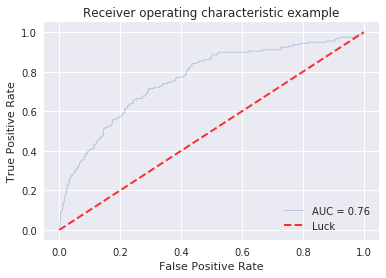

In [44]:
probas_  = gnb.fit(X_train, Y_train).predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.3, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()